In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from common import settings
from common.dataset import StockDataSet
from envs.fast_trading_env import FastTradingEnv
from evaluation.evaluator import Evaluator

In [12]:
ds = StockDataSet()
stock_codes = ds.stock_list(min_days=settings.EPISODE_LENGTH)
valid_stock_codes = stock_codes[ds.TRAIN_SIZE:ds.TRAIN_SIZE+ds.VALID_SIZE]
evalator = Evaluator(model_dir=settings.MODEL_DATA_DIR, input_shape=(settings.EPISODE_LENGTH, settings.FEATURE_NUM))

actions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]
signals:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1]
predict_reward:  0.00760692
real_reward:  -0.0286944943362


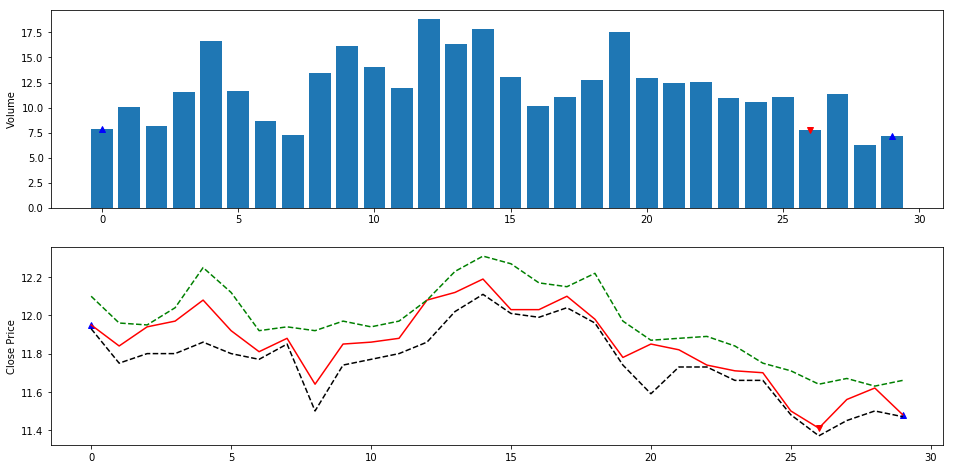

In [26]:
env = FastTradingEnv(name=np.random.choice(valid_stock_codes, 1)[0], days=settings.EPISODE_LENGTH, use_adjust_close=False)
evals_history = evalator.evaluate_on_env(model_name='resnet_18.1512706346.h5', env=env)
evalator.show_plot(evals_history)